## implementation of Constrained Least Squares Filter based on PSNR and MSSIM

## Turbulence degradation

### importing necessary libraries 

In [1]:
from skimage.metrics import structural_similarity
import math
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.util import random_noise

### Reading Image

In [2]:
img = cv2.imread('aerial_view.tif',0)
img = cv2.resize(img,(525 , 525))
img = cv2.normalize(img, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)

### Defining discrete fourier transform function

In [3]:
def dftuv(M, N) :
      
    u =np.linspace(0, M-1,M)
    v =np.linspace(0, N-1,N)   
    idx = np.where(u > M/2)
    u[idx] = u[idx] - M
    idy = np.where(v > N/2)
    v[idy] = v[idy] - N
    V, U = np.meshgrid(v, u)
    
    return V,U

In [4]:
f = np.fft.fft2(img)
mag = np.abs(f)
ang = np.angle(f)
magnitude_spectrum = 20*np.log(np.abs(f))

In [5]:
m,n = f.shape 
v,u = dftuv(m, n)

### Defining turbulance function (degradation function)

In [6]:
k=0.0015
H_turb= np.exp(-k*(u**2 + v**2)**(5/6))
HF_turb =np.multiply(f, H_turb)

In [7]:
HF_turb =np.multiply(f, H_turb)
h_conv_f = np.real (np.fft.ifft2(HF_turb))

### Adding gaussian noise with zero mean and var=0.1

In [8]:
noise=np.zeros((525,525),dtype=np.float64)
noise=cv2.randn(noise,0,0.1)
noise_freq = np.fft.fft2(noise)
G_freq =noise_freq + HF_turb

### Degraded Image (turbulance effect + noise)

In [9]:
noise_turb_space = np.real (np.fft.ifft2(G_freq))

### Laplacian Kernel

In [10]:
p = np.array([  [0 ,-1, 0] , [-1,4,-1] , [0,-1,0]  ]  )
p_pad = np.pad(p, (261,261), 'constant')   
p_f = np.fft.fft2(p_pad )
mag = np.abs(p_f)
ang = np.angle(p_f)

### Initializing

In [11]:
score = np.zeros((100,))
psnr = np.zeros((100,))
clsf_f =  np.zeros((525,525,100)).astype(np.complex128)
filtered_in_f = np.zeros((525,525,100)).astype(np.complex128)
filtered_in_s = np.zeros((525,525,100))
filtered_in_s_new= np.zeros((525,525,100))
gamma = np.linspace(0,2,100)

### Iteration for find Best gamma value

In [12]:
for i in range(0,100):

    clsf_f[:,:,i] =  (np.conj(H_turb)) /( (  (np.abs(H_turb))**2 ) + gamma[i]*(np.abs(p_f))**2    )

    filtered_in_f[:,:,i]  = clsf_f[:,:,i]  *G_freq 
    
    filtered_in_s[:,:,i] = np.real (np.fft.ifft2(filtered_in_f[:,:,i]))
    
    filtered_in_s = cv2.normalize(filtered_in_s, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
           
    (score[i], diff) = structural_similarity(img, filtered_in_s[:,:,i],data_range=img.max() - img.min(), full=True)
    psnr[i] = cv2.PSNR(img, filtered_in_s[:,:,i])

In [13]:
best_score_indice = np.where(score == np.amax(score))

In [14]:
best_psnr_indice = np.where(psnr == np.amax(psnr))

### Best reported value for gamma based on PSNR and MSSIM

In [15]:
print ('gamma for max MSSIM = ', gamma[best_score_indice] ,'\ngamma for max PSNR = ', gamma[best_psnr_indice])

gamma for max MSSIM =  [0.84848485] 
gamma for max PSNR =  [1.17171717]


## Figures

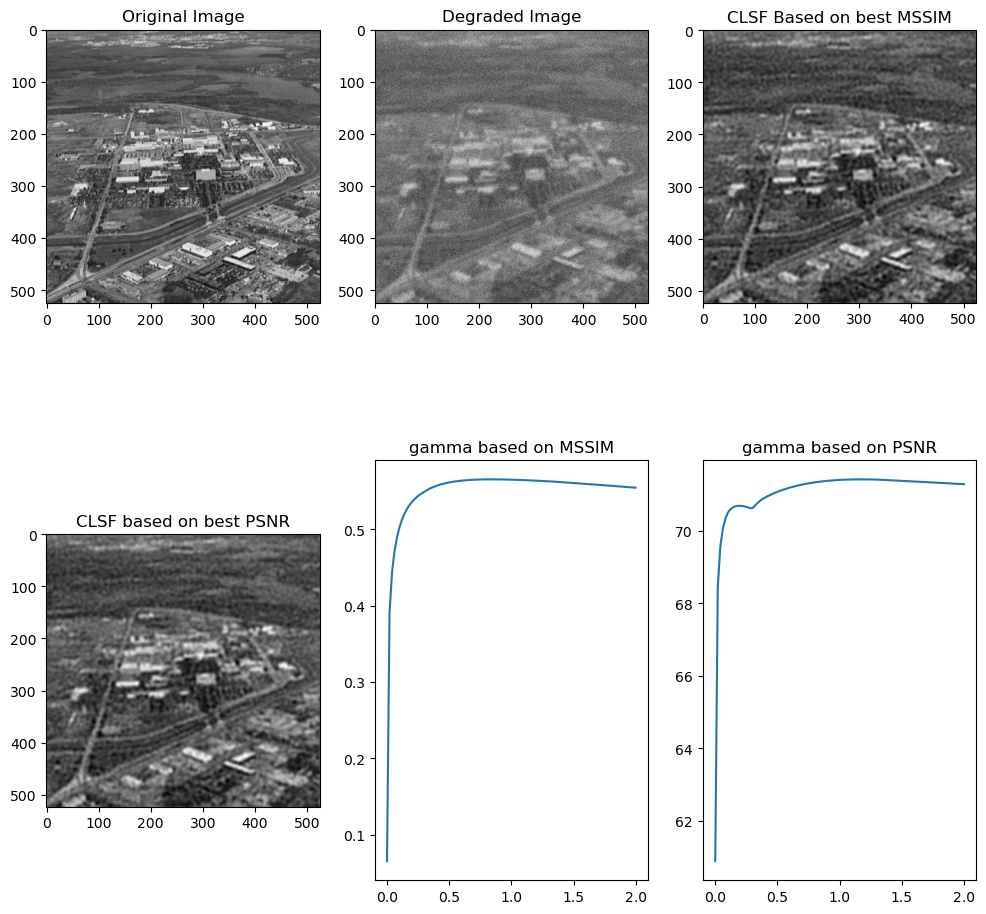

In [102]:
fig2 = plt.figure (figsize = (12,12))
ax1 = fig2.add_subplot (2,3,1)
ax1.imshow(img , cmap = 'gray')
ax1.title.set_text ('Original Image')

ax2 = fig2.add_subplot (2,3,2)
ax2.imshow (noise_turb_space , cmap = 'gray')
ax2.title.set_text ('Degraded Image')

ax3= fig2.add_subplot (2,3,3)
ax3.imshow (filtered_in_s[1:524,:,np.argmax(score)] , cmap='gray')
ax3.title.set_text('CLSF Based on best MSSIM')

ax4= fig2.add_subplot (2,3,4)
ax4.imshow (filtered_in_s[1:524,:,np.argmax(psnr)] , cmap='gray')
ax4.title.set_text('CLSF based on best PSNR')

ax5= fig2.add_subplot (2,3,5)
p1 = ax5.plot(gamma,score)
ax5.title.set_text('gamma based on MSSIM')

ax6= fig2.add_subplot (2,3,6)
p2 = ax6.plot(gamma,psnr)
ax6.title.set_text('gamma based on PSNR')